In [32]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [33]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [34]:
from __future__ import print_function
from numpy import *
from scipy import *
import netCDF4 as nc
import numpy as np
import scipy as sp
import seawater
import datetime as dt

""
from salishsea_tools import (
    nc_tools,
    viz_tools, 
    geo_tools,
    tidetools
)
import matplotlib.pyplot as plt
#matplotlib.use('Agg')
import matplotlib.patches as patches
plt.style.use('seaborn-whitegrid')
import netCDF4 as nc

import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/CCCma_src')
sys.path.append('/data/tjarniko/MEOPAR/tools/SalishSeaTools/salishsea_tools/')
import mocsy
import river_201702 as rv
import mocsy
import CCCma
import CCCma_stations as cs
from matplotlib import reload
import arrow
import gsw

%matplotlib inline

In [35]:
starts = ['2015-01-01','2015-02-01','2015-03-01','2015-04-01','2015-05-01',\
          '2015-06-01','2015-07-01','2015-08-01','2015-09-01',\
         '2015-10-01','2015-11-01','2015-12-01']
ends = ['2015-01-31','2015-02-28','2015-03-31','2015-04-30','2015-05-31',\
          '2015-06-30','2015-07-31','2015-08-31','2015-09-30',\
         '2015-10-31','2015-11-30','2015-12-31']

bdir = '/results2/SalishSea/hindcast.201812_annex/'
sdir = '/data/tjarniko/results/BASEPARTY/ncs/'

figstring = 'BR_2015_'

In [36]:

thalweg_file='/home/sallen/MEOPAR/Tools/bathymetry/thalweg_working.txt'
thalweg_pts = np.loadtxt(thalweg_file, delimiter=' ', dtype=int)


In [37]:
print(np.shape(thalweg_pts))
# print(np.shape(thalweg))

(1533, 2)


In [38]:
def make_nclen(start,end,ftype, bdir, sdir):
    base_ar = []
    sens_ar = []
    start_run = arrow.get(start)
    end_run = arrow.get(end)
    arrow_array = []
    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)
    
    #print('days: '+str(len(arrow_array)))
    dayslen = len(arrow_array)
    hovmoller_base = np.zeros([1533,40,dayslen])
    hovmoller_sens = np.zeros([1533,40,dayslen])

    for i in range(0,dayslen):
        tdate = arrow_array[i][0]
        ddmmmyy = tdate.format('DDMMMYY').lower()
        ymd = tdate.format('YYYYMMDD')
        #nc_base = bdir  + ddmmmyy + '/SalishSea_1d_*_' + ftype +'_T.nc'
        nc_sens = sdir + '/SKOG_1d_*'+ ftype +'_T_' + ymd + '-' + ymd + '.nc'
        #tnc_base = glob.glob(nc_base) 
        tnc_sens = glob.glob(nc_sens)
        #print(tnc_sens)
        #base_ar.append(tnc_base[0])
        sens_ar.append(tnc_sens[0])
        
    return base_ar, sens_ar

In [39]:
w2 = nc.Dataset('/data/tjarniko/results/BASEPARTY/ncs/SKOG_1d_20150131_20150301_carp_T_20150201-20150201.nc')
print(w2)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    name: SKOG_1d_20150131_20150301
    description: auxilary variables
    title: auxilary variables
    Conventions: CF-1.6
    timeStamp: 2019-Apr-20 15:37:02 GMT
    uuid: 650b56c5-e7df-4aad-adf7-32503ebc9cc2
    dimensions(sizes): axis_nbounds(2), x(398), y(898), nvertex(4), deptht(40), time_counter(1)
    variables(dimensions): float32 nav_lat(y,x), float32 nav_lon(y,x), float32 bounds_lon(y,x,nvertex), float32 bounds_lat(y,x,nvertex), float32 area(y,x), float32 deptht(deptht), float32 deptht_bounds(deptht,axis_nbounds), float32 PAR(time_counter,deptht,y,x), float64 time_centered(time_counter), float64 time_centered_bounds(time_counter,axis_nbounds), float64 time_counter(time_counter), float64 time_counter_bounds(time_counter,axis_nbounds), float32 sigma_theta(time_counter,deptht,y,x), float32 e3t(time_counter,deptht,y,x), float32 dissolved_inorganic_carbon(time_counter,deptht,y,x), float32 tota

In [40]:
def combine_files(files, var, dep_lvl):

    time = np.array([])
    var_list = []
    i = 0
    for f in files:
        G = nc.Dataset(f)
        if var == 'co2_flux_mmol_m2_s':
            var_tmp = G.variables[var][:]
            var_tmp2=var_tmp[0,:,:]
        else:
            var_tmp = G.variables[var][:]
            var_tmp2=var_tmp[0,dep_lvl,:,:]
        
        var_list.append(var_tmp2)
        i = i+1
        
    return var_list



In [41]:
dicstor = np.zeros([12,898,398])
fluxstor = np.zeros([12,898,398])
tastor = np.zeros([12,898,398])
tempstor = np.zeros([12,898,398])
salstor = np.zeros([12,898,398])

In [42]:


for i in range(0,12):
    start = starts[i]
    end = ends[i]
    try:
        print(start)
        base_ar, sens_ar = make_nclen(start,end,'carp',bdir,sdir)
        base_arG,sens_arG = make_nclen(start,end,'grid',bdir,sdir)
        base_arP,sens_arP = make_nclen(start,end,'ptrc',bdir,sdir)
        print('DIC')
        dic_sens = combine_files(sens_ar,'dissolved_inorganic_carbon',0)
        dic_avg = np.mean(dic_sens,axis=0)
        dicstor[i,:,:] = dic_avg
        print('flux')
        flux_sens = combine_files(sens_ar,'co2_flux_mmol_m2_s',0)
        flx_avg = np.mean(flux_sens,axis=0)
        fluxstor[i,:,:] = flx_avg
        print('TA')
        ta_sens = combine_files(sens_ar,'total_alkalinity',0)
        ta_avg = np.mean(ta_sens,axis=0)
        tastor[i,:,:] = ta_avg
        print('SAL')
        sal_sens = combine_files(sens_arG,'vosaline',0)
        sal_avg = np.mean(sal_sens,axis=0)
        salstor[i,:,:] = sal_avg
        print('TEMP')
        temp_sens = combine_files(sens_arG,'votemper',0)
        temp_avg = np.mean(temp_sens,axis=0)
        tempstor[i,:,:] = temp_avg
    
    except IndexError as error:
        print('out of days?')

2015-01-01
DIC
flux
TA
SAL
TEMP
2015-02-01
DIC
flux
TA
SAL
TEMP
2015-03-01
DIC
flux
TA
SAL
TEMP
2015-04-01
DIC
flux
TA
SAL
TEMP
2015-05-01
DIC
flux
TA
SAL
TEMP
2015-06-01
DIC
flux
TA
SAL
TEMP
2015-07-01
DIC
flux
TA
SAL
TEMP
2015-08-01
out of days?
2015-09-01
out of days?
2015-10-01
out of days?
2015-11-01
out of days?
2015-12-01
out of days?


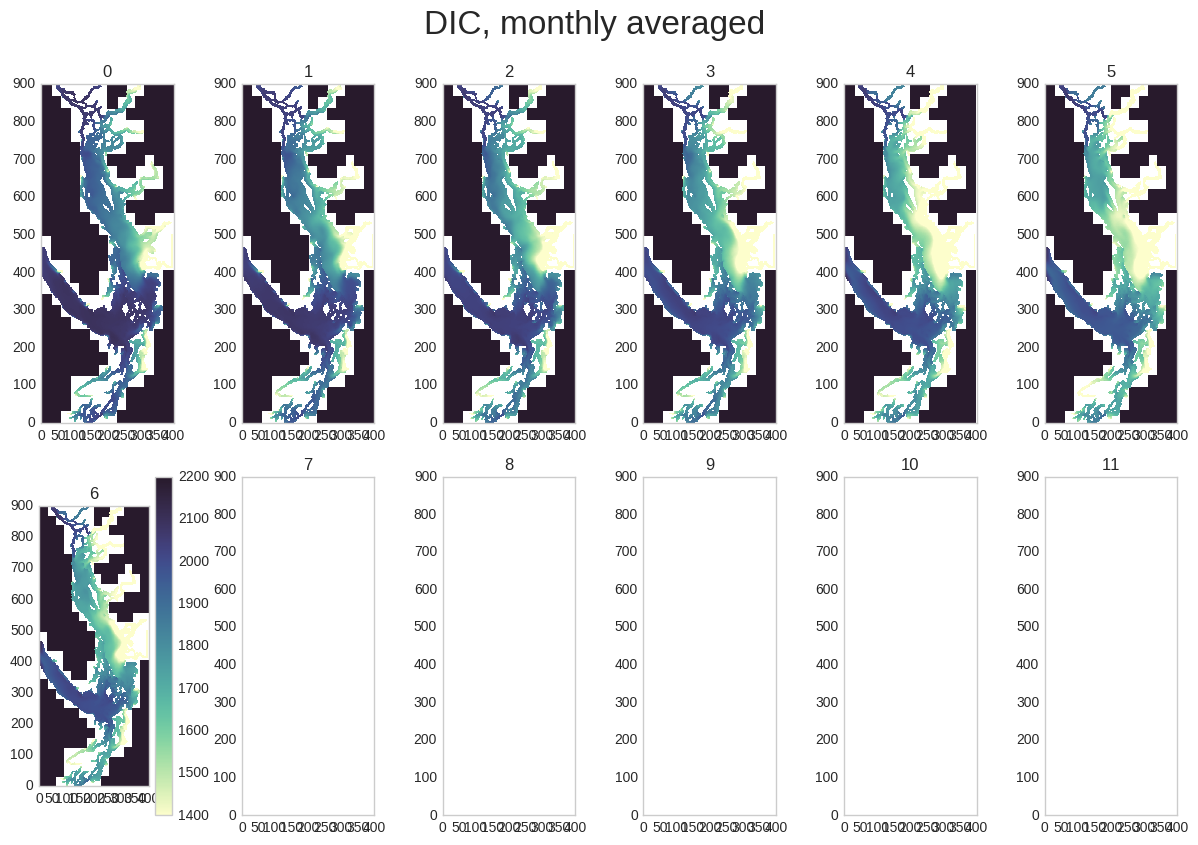

In [43]:
t_cmap = cm.cm.deep
t_vmin = 1400
t_vmax = 2200
fig = plt.figure(figsize=(12,8))
nop = 12
for i in range(0,nop):
    ax = fig.add_subplot(2,nop/2,i+1)
    sd = dicstor[i,:,:]
    tplt = np.ma.masked_values(sd,0)
    mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=t_vmin, vmax=t_vmax)
    
    if (i == 6) | (i == 12):
        cbar = fig.colorbar(mesh, ax=ax)
    ax.set_title(str(i))
    viz_tools.set_aspect(ax)    
fig.tight_layout()
fig.suptitle('DIC, monthly averaged', y=1.05, fontsize=24)
t_figstring = './FIGS/' + figstring + 'DICmon.jpg'
fig.savefig(t_figstring)

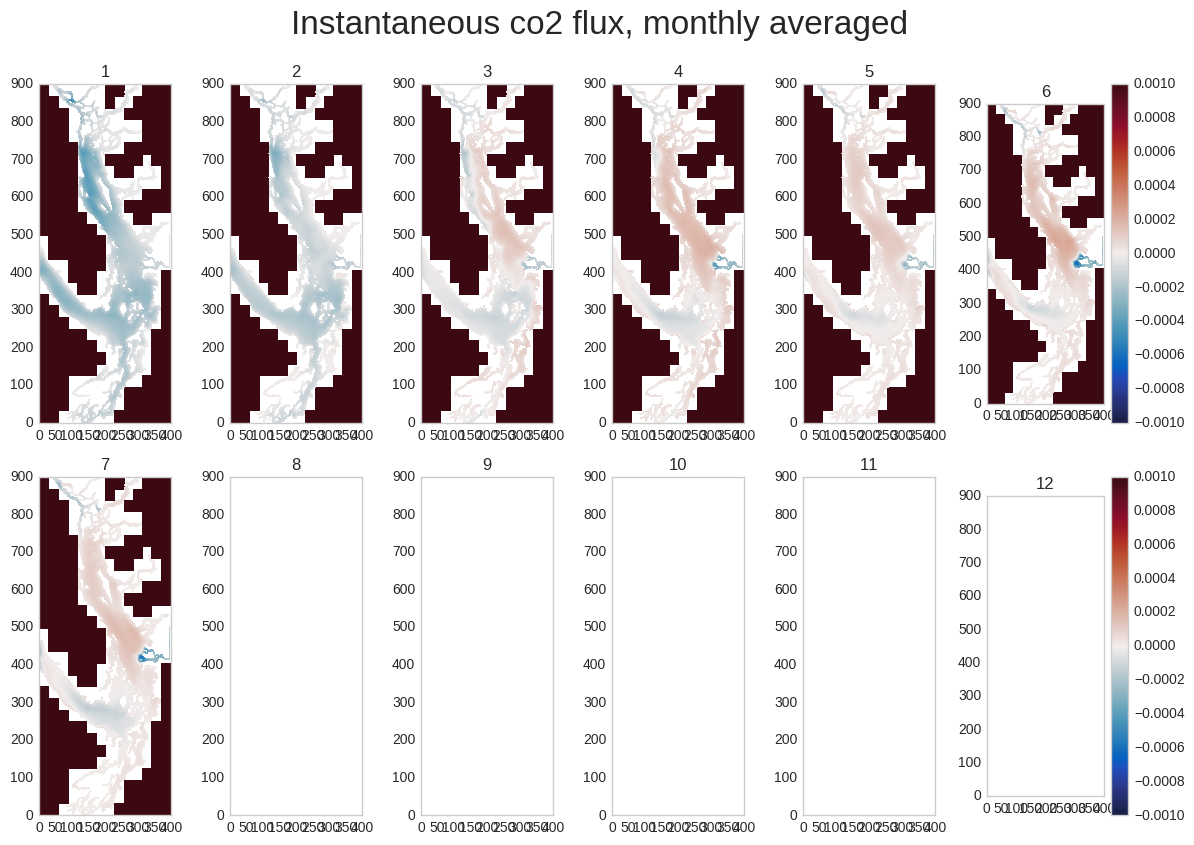

In [44]:
t_cmap = cm.cm.balance
t_vmin = -0.001
t_vmax = 0.001
fig = plt.figure(figsize=(12,8))
nop = 12
for i in range(1,nop+1):
    ax = fig.add_subplot(2,nop/2,i)
    sd = fluxstor[i-1,:,:]
    tplt = np.ma.masked_values(sd,0)
    mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=t_vmin, vmax=t_vmax)
    
    if (i == 6) | (i == 12):
        cbar = fig.colorbar(mesh, ax=ax)
    ax.set_title(str(i))
    viz_tools.set_aspect(ax)    
fig.tight_layout()
fig.suptitle('Instantaneous co2 flux, monthly averaged', y=1.05, fontsize=24)
t_figstring = './FIGS/' + figstring + 'CO2flxmon.jpg'
fig.savefig(t_figstring)

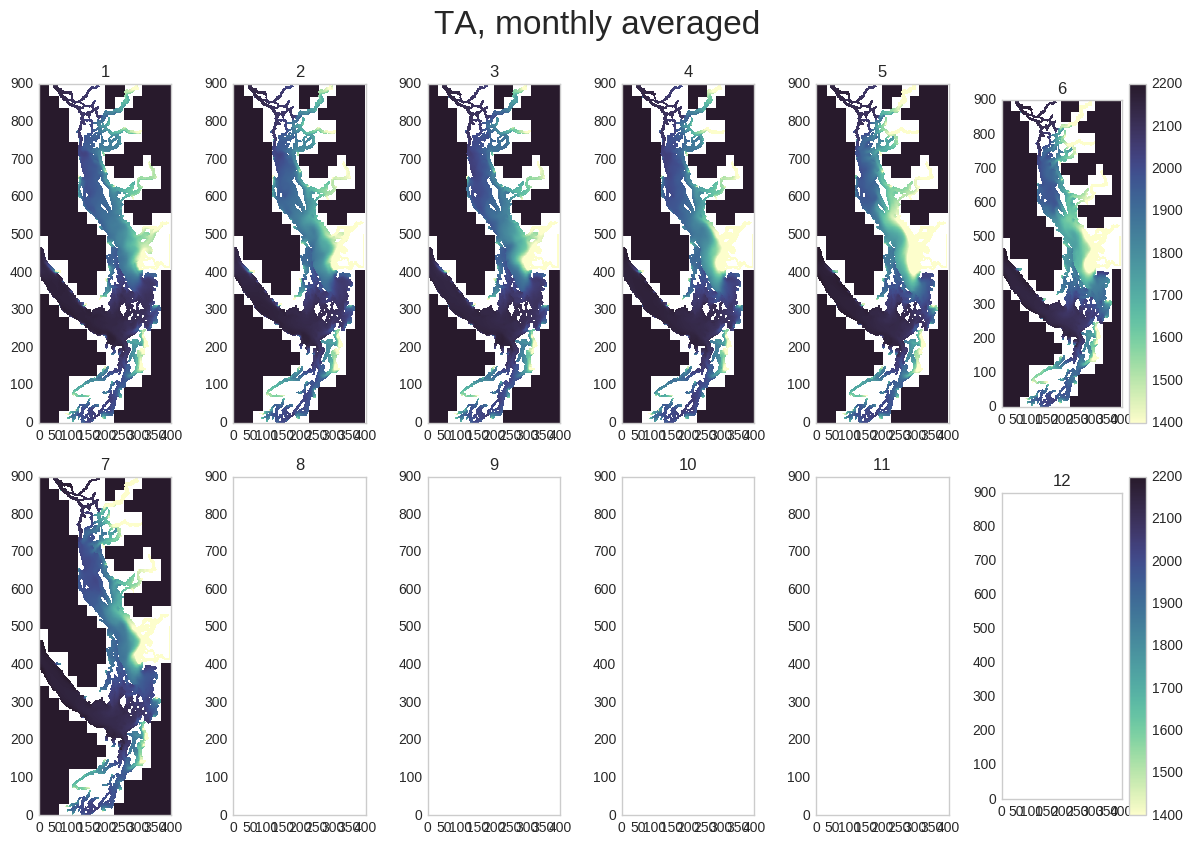

In [45]:
t_cmap = cm.cm.deep
t_vmin = 1400
t_vmax = 2200
fig = plt.figure(figsize=(12,8))
nop = 12
for i in range(1,nop+1):
    ax = fig.add_subplot(2,nop/2,i)
    sd = tastor[i-1,:,:]
    tplt = np.ma.masked_values(sd,0)
    mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=t_vmin, vmax=t_vmax)
    
    if (i == 6) | (i == 12):
        cbar = fig.colorbar(mesh, ax=ax)
    ax.set_title(str(i))
    viz_tools.set_aspect(ax)    
fig.tight_layout()
fig.suptitle('TA, monthly averaged', y=1.05, fontsize=24)
t_figstring = './FIGS/' + figstring + 'TAmon.jpg'
fig.savefig(t_figstring)


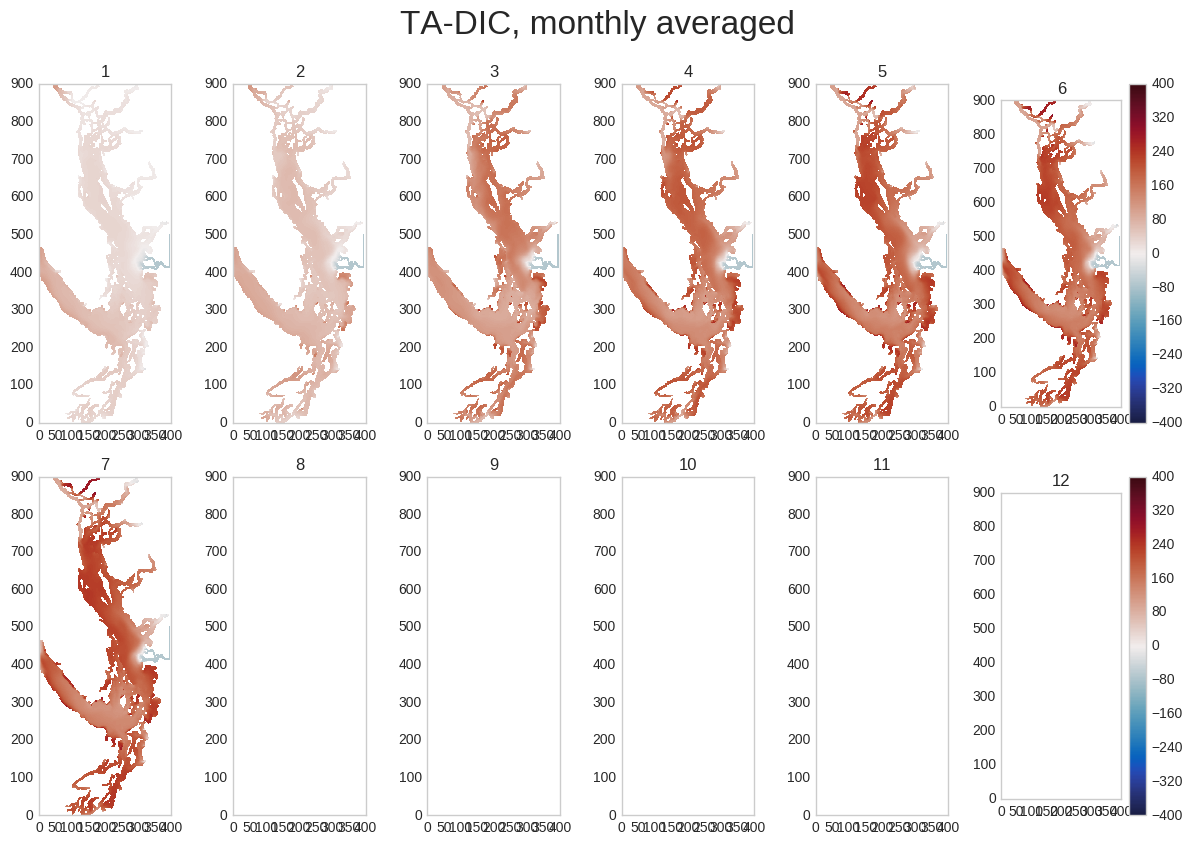

In [46]:
t_cmap = cm.cm.balance
t_vmin = -400
t_vmax = 400
fig = plt.figure(figsize=(12,8))
nop = 12
for i in range(1,nop+1):
    ax = fig.add_subplot(2,nop/2,i)
    sd = tastor[i-1,:,:] - dicstor[i-1,:,:]
    tplt = np.ma.masked_values(sd,0)
    mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=t_vmin, vmax=t_vmax)
    
    if (i == 6) | (i == 12):
        cbar = fig.colorbar(mesh, ax=ax)
    ax.set_title(str(i))
    viz_tools.set_aspect(ax)    
fig.tight_layout()
fig.suptitle('TA-DIC, monthly averaged', y=1.05, fontsize=24)
t_figstring = './FIGS/' + figstring + 'DIC-TAmon.jpg'
fig.savefig(t_figstring)

In [47]:
np.shape(dicstor)

(12, 898, 398)

In [48]:
tsra = np.ravel(salstor)
ttera = np.ravel(tempstor)
ttara = np.ravel(tastor) * 1e-3
tdra = np.ravel(dicstor) * 1e-3

def oned_moxy(tsal, ttemp, tdic, tta, pres_atm, depth_this):
    
    tzero = np.zeros_like(tsra)
    tpressure = np.zeros_like(tsra)
    tdepth = np.zeros_like(tsra)
    tpressure[:] = pres_atm
    tdepth[:] = depth_this
    tzero = tpressure * 0 
        
    tsra_psu = tsra*35/35.16504
    ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
    
    return pH, OmegaA, pco2

In [49]:
tsra = np.ravel(salstor)
ttera = np.ravel(tempstor)
ttara = np.ravel(tastor) * 1e-3
tdra = np.ravel(dicstor) * 1e-3
pH, OmegaA, pco2 = oned_moxy(tsra, ttera, tdra, ttara, 1, 0)

pHr = pH.reshape(12,898,398)
OmegaAr = OmegaA.reshape(12,898,398)
pco2r = pco2.reshape(12,898,398)


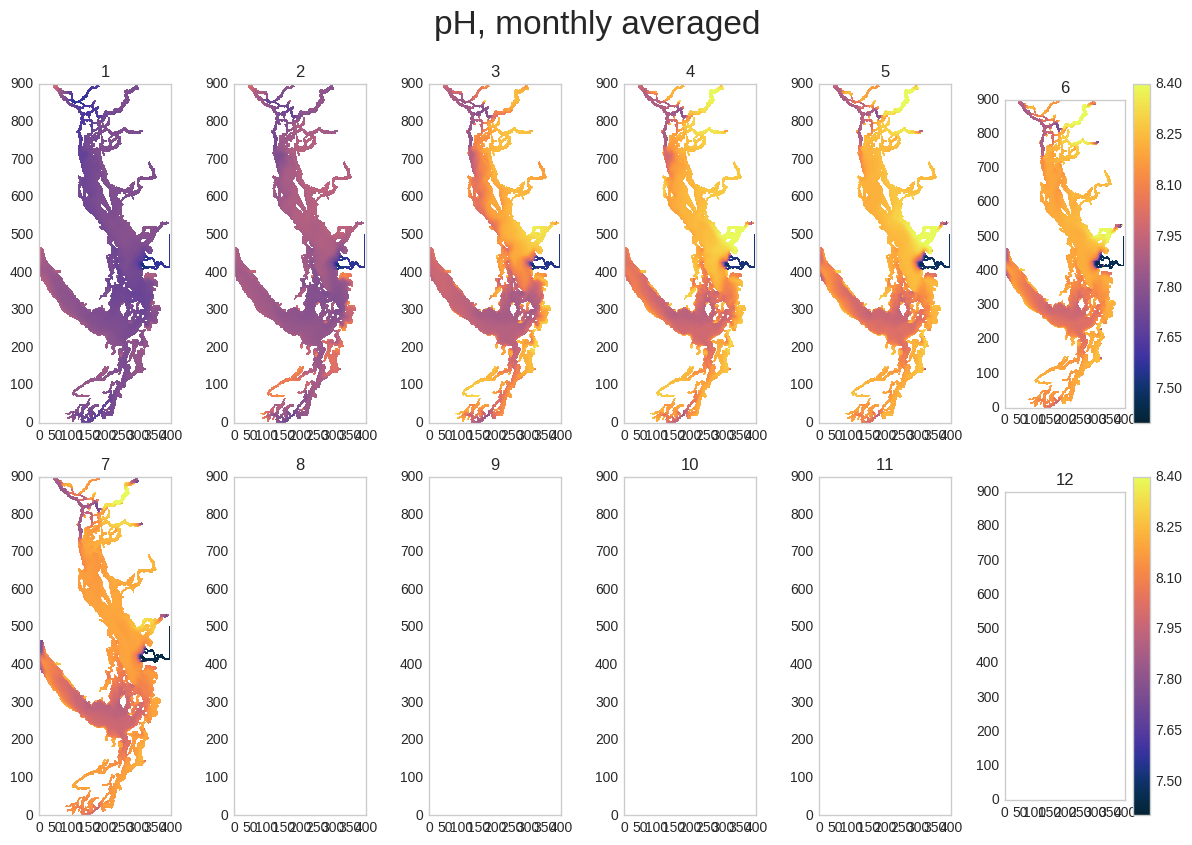

In [50]:
t_cmap = cm.cm.thermal
t_vmin = 7.4
t_vmax = 8.4
fig = plt.figure(figsize=(12,8))
nop = 12
for i in range(1,nop+1):
    ax = fig.add_subplot(2,nop/2,i)
    sd = pHr[i-1,:,:]
    tplt = np.ma.masked_values(sd,1e+20)
    mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=t_vmin, vmax=t_vmax)
    
    if (i == 6) | (i == 12):
        cbar = fig.colorbar(mesh, ax=ax)
    ax.set_title(str(i))
    viz_tools.set_aspect(ax)    
fig.tight_layout()
fig.suptitle('pH, monthly averaged', y=1.05, fontsize=24)
t_figstring = './FIGS/' + figstring + 'pHmon.jpg'
fig.savefig(t_figstring)

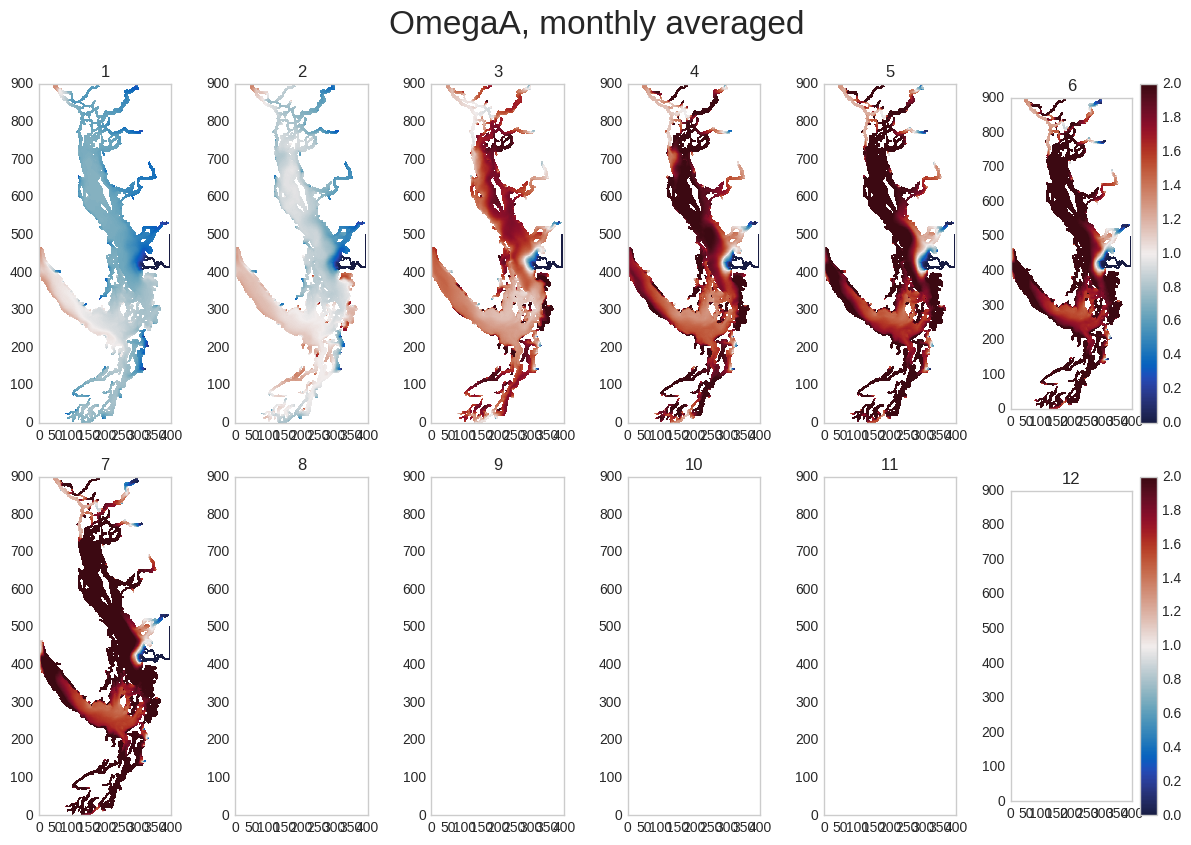

In [51]:
t_cmap = cm.cm.balance
t_vmin = 0
t_vmax = 2
fig = plt.figure(figsize=(12,8))
nop = 12
for i in range(1,nop+1):
    ax = fig.add_subplot(2,nop/2,i)
    sd = OmegaAr[i-1,:,:]
    tplt = np.ma.masked_values(sd,1e+20)
    mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=t_vmin, vmax=t_vmax)
    
    if (i == 6) | (i == 12):
        cbar = fig.colorbar(mesh, ax=ax)
    ax.set_title(str(i))
    viz_tools.set_aspect(ax)    
fig.tight_layout()
fig.suptitle('OmegaA, monthly averaged', y=1.05, fontsize=24)
t_figstring = './FIGS/' + figstring + 'OmAmon.jpg'
fig.savefig(t_figstring)

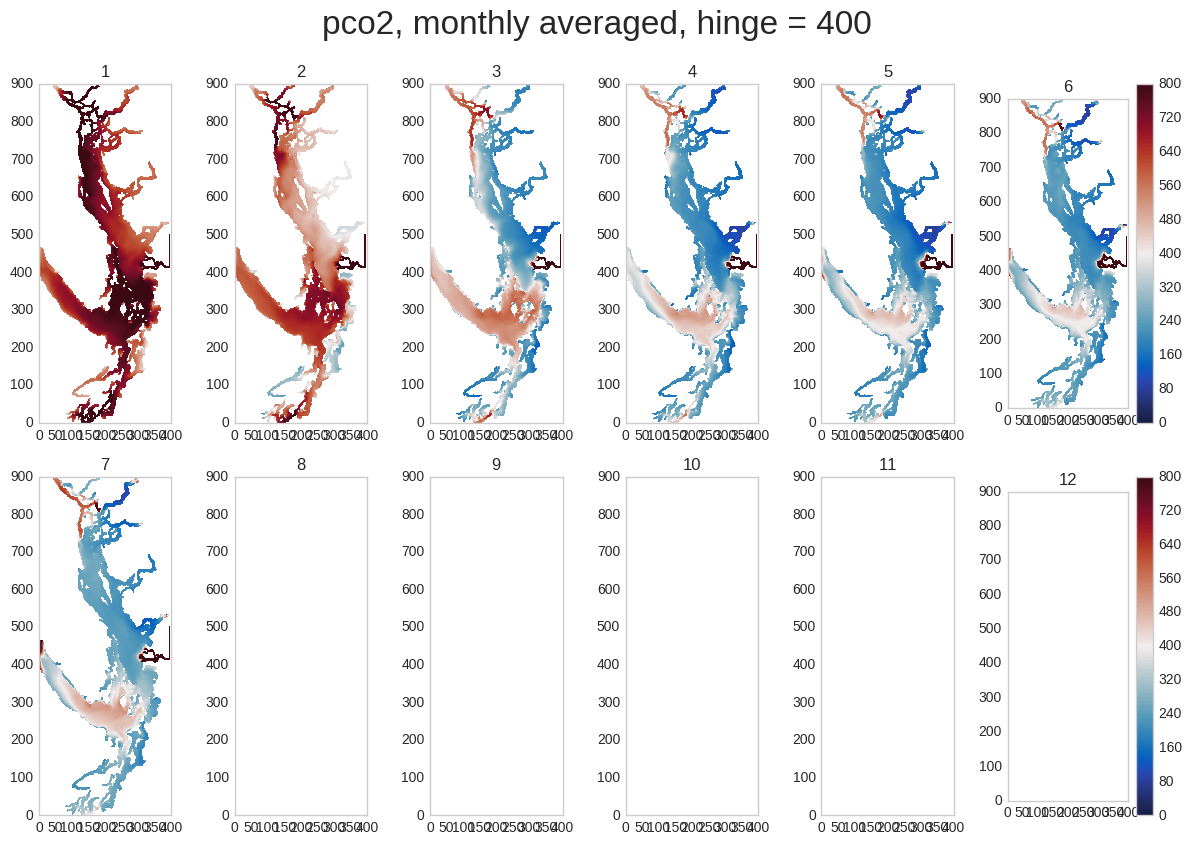

In [52]:
t_cmap = cm.cm.balance
t_vmin = 0
t_vmax = 800
fig = plt.figure(figsize=(12,8))
nop = 12
for i in range(1,nop+1):
    ax = fig.add_subplot(2,nop/2,i)
    sd = pco2r[i-1,:,:]
    tplt = np.ma.masked_values(sd,1e+20)
    mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=t_vmin, vmax=t_vmax)
    
    if (i == 6) | (i == 12):
        cbar = fig.colorbar(mesh, ax=ax)
    ax.set_title(str(i))
    viz_tools.set_aspect(ax)    
fig.tight_layout()
fig.suptitle('pco2, monthly averaged, hinge = 400', y=1.05, fontsize=24)
t_figstring = './FIGS/' + figstring + 'pco2mon_400.jpg'
fig.savefig(t_figstring)

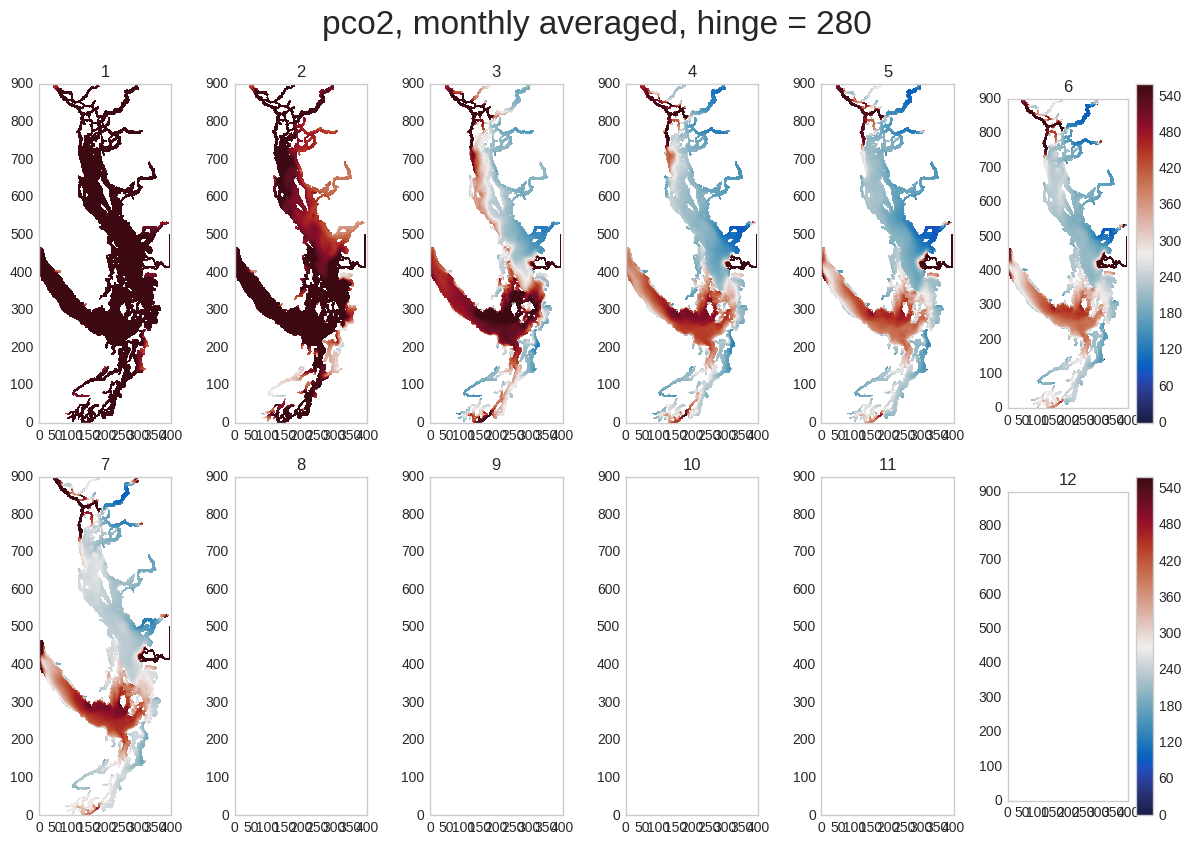

In [53]:
t_cmap = cm.cm.balance
t_vmin = 0
t_vmax = 280*2
fig = plt.figure(figsize=(12,8))
nop = 12
for i in range(1,nop+1):
    ax = fig.add_subplot(2,nop/2,i)
    sd = pco2r[i-1,:,:]
    tplt = np.ma.masked_values(sd,1e+20)
    mesh = ax.pcolormesh(tplt, cmap=t_cmap, vmin=t_vmin, vmax=t_vmax)
    
    if (i == 6) | (i == 12):
        cbar = fig.colorbar(mesh, ax=ax)
    ax.set_title(str(i))
    viz_tools.set_aspect(ax)    
fig.tight_layout()
fig.suptitle('pco2, monthly averaged, hinge = 280', y=1.05, fontsize=24)
t_figstring = './FIGS/' + figstring + 'pco2mon_280.jpg'
fig.savefig(t_figstring)